# Objectives

1. Estimate Clock Model
1. Filter Outliers
    - Plot Prune Compare: Divtree
    - Plot Prune Compare: Timetree
1. Add Clock Model to Dataframe

NOTE: Filter outliers after clock model estimated?

---
# Setup

## Modules

In [1]:
# Bio
import treetime
from Bio import Phylo

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('whitegrid')

# Stats
import pandas as pd

# System IO
import dill
import copy
import os
import io
import sys

## Paths

In [2]:
# snakemake output
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"

# jupyter notebook output
tree_df_path = "../../results/parse_tree/parse_tree.tsv"
tree_df_dill = "../../results/parse_tree/parse_tree.df.obj"
tree_path = "../../results/parse_tree/parse_tree.nwk"
auspice_latlon_path = "../../results/parse_tree/parse_tree_latlon.tsv"
auspice_colors_path = "../../results/parse_tree/parse_tree_colors.tsv"

# static dir
auspice_config_path = "../../config/auspice_config.json"
auspice_remote_dir_path = "../../auspice/"


outdir = "../../results/clock_model"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "clock_model"

# Clock model params

N_IQD = 3
MAX_ITER = 3
TC = "skyline"

## Import Tree

In [4]:
tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# 1. Filter Outlier Tips

## Parse Tip Dates

In [6]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Estimate Clock Model

In [7]:
# Initialize stdout capture
# print("Estimating clock model...")
# old_stdout = sys.stdout
# new_stdout = io.StringIO()
# sys.stdout = new_stdout

# branch_length_mode:input --> tMRCA ~20,000 YBP

tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,                     
                       tree=tree, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,
                      )

# 11:26 AM -
tt.run(
    # Stable Parameters
    max_iter=3,    
    n_iqd=N_IQD,   
    verbose=4,    
    infer_gtr=True,  
    use_covariation=False,     
    root=tt.tree.root,       
    resolve_polytomies=True,     
    vary_rate=True,    
    relaxed_clock={"slack" : 0.1, "coupling": 0},     
    # Variable Parameters   
    branch_length_mode = "joint", # joint or marginal      
    time_marginal=True,   # True, False or "assign"  
    Tc=TC,    
    )

tt.tree.ladderize(reverse=False)

# Save stdout to file
# output = new_stdout.getvalue()
# out_path = os.path.join(outdir, SCRIPT_NAME + "_estimate.log") 
# with open(out_path, "w") as file:
#     file.write(output)
# # Restore stdout
# sys.stdout = old_stdout
# print("Standard output restored, logging to file disabled.")


0.00	-TreeAnc: set-up

1.26	-SequenceData: loaded alignment.
1.26	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.26	-SeqData: making compressed alignment...

4.13	-SequenceData: constructed compressed alignment...
4.45	--ClockTree: Setting precision to level 2

4.53	-ClockTree._assign_dates: assigned date contraints to 634 out of 634 tips.

4.53	-TreeAnc.optimize_tree: sequences...

4.53	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

4.53	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
4.53	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
4.53	---TreeAnc._ml_anc_jo

129.68	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
129.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
129.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
129.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
129.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
129.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
129.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
129.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
129.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
  

223.02	--optimized Tc to 0.000106
relaxed_clock {'slack': 0.1, 'coupling': 0}
223.85	--TreeTime.relaxed_clock: slack=0.100000, coupling=0.000000

223.89	-TreeTime.resolve_polytomies: resolving multiple mergers...
223.93	---TreeTime._poly.merge_nodes: creating new node as child of NODE35
223.93	---TreeTime._poly.merge_nodes: Delta-LH = 0.19
223.96	---TreeTime._poly.merge_nodes: creating new node as child of NODE35
223.96	---TreeTime._poly.merge_nodes: Delta-LH = 0.185
223.99	---TreeTime._poly.merge_nodes: creating new node as child of NODE41
223.99	---TreeTime._poly.merge_nodes: Delta-LH = 0.286
224.05	---TreeTime._poly.merge_nodes: creating new node as child of NODE107
224.05	---TreeTime._poly.merge_nodes: Delta-LH = 0.135
224.09	---TreeTime._poly.merge_nodes: creating new node as child of NODE107
224.09	---TreeTime._poly.merge_nodes: Delta-LH = 0.192
224.11	---TreeTime._poly.merge_nodes: creating new node as child of NODE107
224.11	---TreeTime._poly.merge_nodes: Delta-LH = 0.161
224.2

342.41	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
342.88	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
342.88	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
342.88	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
342.88	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
342.88	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
342.88	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
342.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
342.89	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
  

361.85	---TreeTime.resolve_polytomies: introduces 39 new nodes

362.00	-TreeAnc.optimize_tree: sequences...

362.00	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint
362.00	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
362.00	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
367.83	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
      	   likelihood sequences...
367.99	---TreeAnc._ml_anc_joint: ...done

368.00	-TreeAnc.optimize_branch_length: running branch length optimization using
      	 jointML ancestral sequences
372.91	--TreeAnc.optimize_tree: Unconstrained sequence LH:-6608074.746851

372.91	-ClockTree: Maximum likelihood tree optimization with temporal
      	 constraints
372.91	--ClockTree.init_date_constraints...
372.91	---ClockTree.init_date_constraints: Initializing branch length
      	   interpolation objects...
401.87	--ClockTree.date2dist: Setting new molecular clock. rate=9.411e-09,
      	  R^2=0.311

626.59	---TreeTime._poly.merge_nodes: creating new node as child of NODE137
626.59	---TreeTime._poly.merge_nodes: Delta-LH = 0.013
626.62	---TreeTime._poly.merge_nodes: creating new node as child of NODE150
626.62	---TreeTime._poly.merge_nodes: Delta-LH = 0.213
626.69	---TreeTime._poly.merge_nodes: creating new node as child of NODE184
626.69	---TreeTime._poly.merge_nodes: Delta-LH = 0.136
626.73	---TreeTime._poly.merge_nodes: creating new node as child of NODE184
626.73	---TreeTime._poly.merge_nodes: Delta-LH = 0.155
626.76	---TreeTime._poly.merge_nodes: creating new node as child of NODE184
626.77	---TreeTime._poly.merge_nodes: Delta-LH = 0.136
626.80	---TreeTime._poly.merge_nodes: creating new node as child of NODE184
626.80	---TreeTime._poly.merge_nodes: Delta-LH = 0.142
626.83	---TreeTime._poly.merge_nodes: creating new node as child of NODE184
626.83	---TreeTime._poly.merge_nodes: Delta-LH = 0.054
626.95	---TreeTime._poly.merge_nodes: creating new node as child of NODE300
626.95	

756.22	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
      	   likelihood sequences...
756.41	---TreeAnc._ml_anc_joint: ...done

756.87	-###ClockTree.calc_rate_susceptibility: run with upper bound of rate
      	 estimate

756.87	-ClockTree: Maximum likelihood tree optimization with temporal
      	 constraints
756.87	--ClockTree.init_date_constraints...
756.87	---ClockTree.init_date_constraints: Initializing branch length
      	   interpolation objects...
787.03	--ClockTree.date2dist: Setting new molecular clock. rate=9.247e-09,
      	  R^2=0.2985
787.03	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
787.03	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
787.03	----ClockTree.init_date_constraints -- WARNING: Branch is

985.09	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
985.69	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
985.69	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
985.69	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
985.69	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
985.69	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
985.69	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
985.69	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
      	    optimized later than present day
985.69	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
  

1125.42	--ClockTree.date2dist: Setting new molecular clock. rate=9.264e-09,
       	  R^2=0.2985
1125.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ignored!
1125.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ignored!
1125.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ignored!
1125.42	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ignored!
1125.43	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ig

## Quick Checks

In [8]:
# Common Ancestor
tt.tree.common_ancestor("NODE0")

Clade(_v=0, bad_branch=False, branch=2.148814885614286e-07, branch_length=2.148814885614286e-07, clock_length=2.148814885614286e-07, date='-4000-09-21', dist2root=0.0, mutation_length=2.148814885614286e-07, name='NODE0', original_length=0.0)

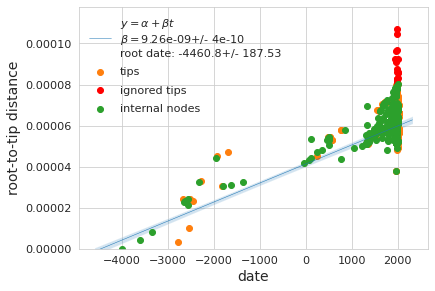

In [9]:
# RTT Regression
tt.plot_root_to_tip(add_internal=True, label=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

# 2. Filter Outliers

## Prune 'Bad' Branches from Tree

In [10]:
tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    n.branch_length=n.mutation_length
    if n.bad_branch:
        n.color = "red"
for n in tt_prune.tree.find_clades():
    n.branch_length=n.mutation_length

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

PRUNING: GCA_001601675.1_ASM160167v1_genomic
PRUNING: GCA_001972405.1_ASM197240v1_genomic
PRUNING: GCA_001972385.1_ASM197238v1_genomic
PRUNING: GCA_001972395.1_ASM197239v1_genomic
PRUNING: GCA_002165475.1_ASM216547v1_genomic
PRUNING: GCA_001972415.1_ASM197241v1_genomic
PRUNING: GCA_001294815.1_ASM129481v1_genomic
PRUNING: GCA_000382505.1_Yersinia_pestis_G1670E_assembly_genomic
PRUNING: GCA_000382545.1_Yersinia_pestis_assembly_genomic
PRUNING: GCA_001188335.1_DYA_1_genomic
PRUNING: GCA_000834275.1_ASM83427v1_genomic
PRUNING: GCA_000834885.1_ASM83488v1_genomic
PRUNING: GCA_008630375.1_ASM863037v1_genomic
PRUNING: GCA_008630375.2_ASM863037v2_genomic
PRUNING: GCA_003086075.1_ASM308607v1_genomic
PRUNING: GCA_003086115.1_ASM308611v1_genomic
PRUNING: GCA_001613865.1_ASM161386v1_genomic


## Plot Prune Comparison: Divtree

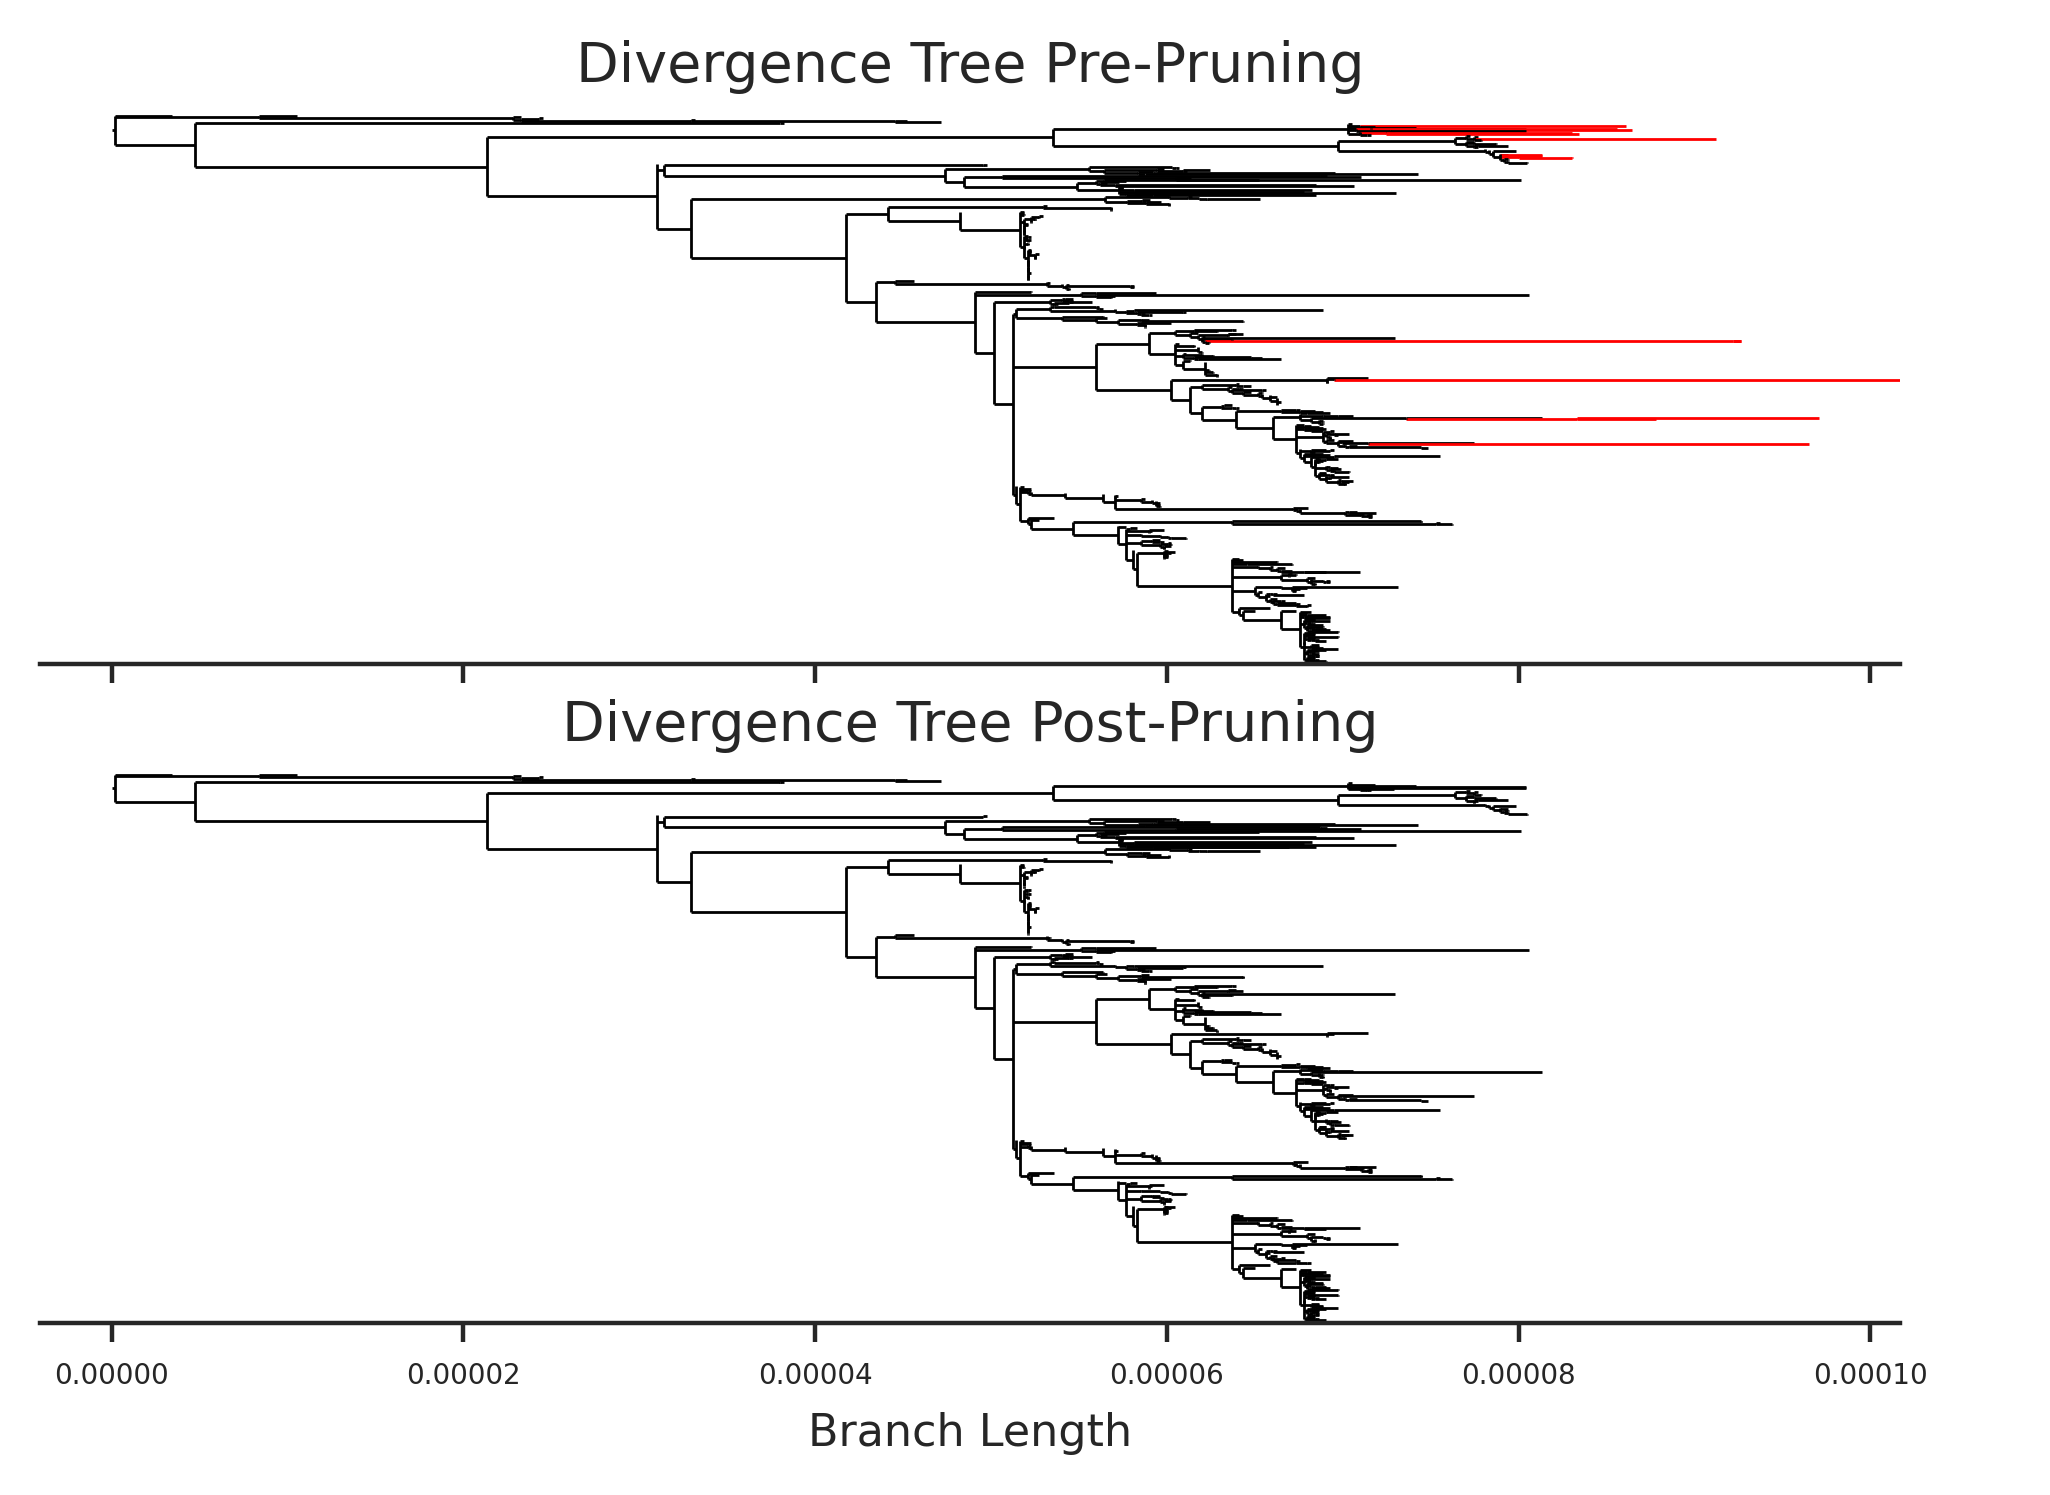

In [11]:
sns.set_style("ticks")
fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)

Phylo.draw(tt_pre.tree,   show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax1,)  
Phylo.draw(tt_prune.tree, show_confidence=False, label_func = lambda x: '', do_show=False, axes=ax2,)

ax1.set_title("Divergence Tree Pre-Pruning")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticks([])
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)

ax2.set_title("Divergence Tree Post-Pruning")
ax2.set_xlabel("Branch Length")
ax2.set_ylabel("")
ax2.set_ylabel("")
ax2.set_yticks([])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["left"].set_visible(False)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-prune." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Plot Prune Comparison: Timetree

1574.98	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years
1596.37	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


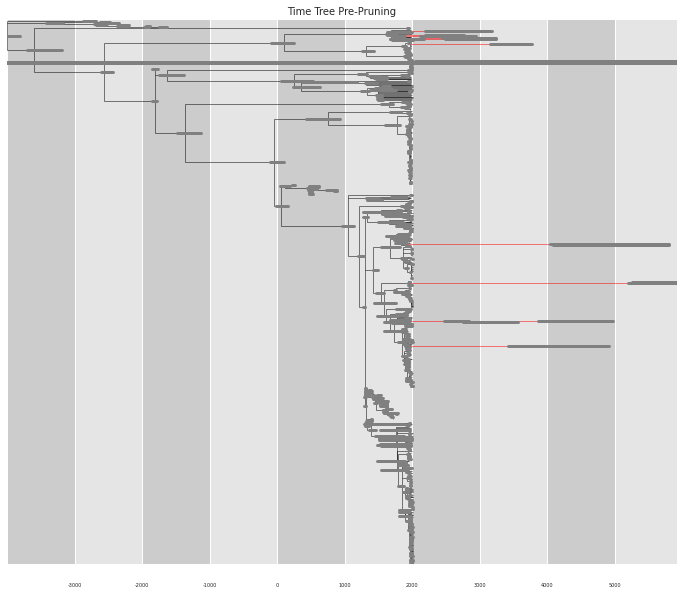

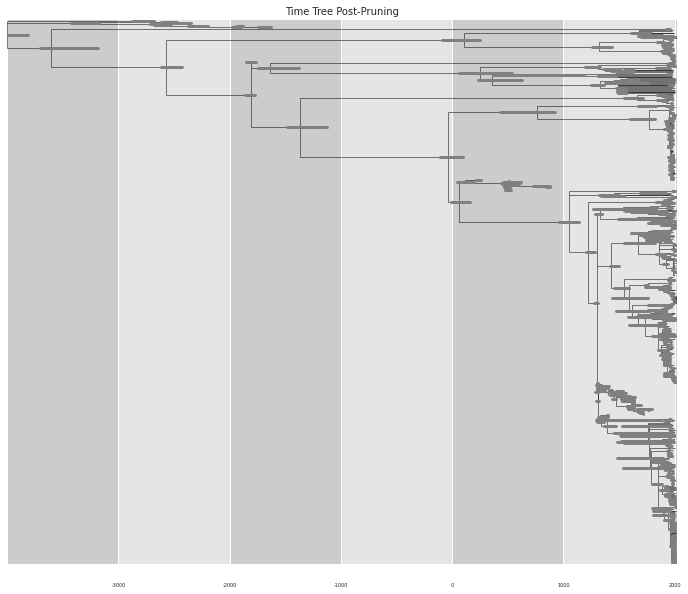

In [12]:
# Pre-pruning
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax1 = treetime.treetime.plot_vs_years(tt_pre, label_func = lambda x:"", do_show=False, confidence=(1-CONFIDENCE, CONFIDENCE))
else:
    fig, ax1 = treetime.treetime.plot_vs_years(tt_pre, label_func = lambda x:"" ,do_show=False)  

ax1.set_title("Time Tree Pre-Pruning")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune-pre." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

# Post-pruning    
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax2 = treetime.treetime.plot_vs_years(tt_prune, label_func = lambda x:"", do_show=False, confidence=(1-CONFIDENCE, CONFIDENCE))
else:
    fig, ax2 = treetime.treetime.plot_vs_years(tt_prune, label_func = lambda x:"" ,do_show=False)  

ax2.set_title("Time Tree Post-Pruning")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-prune-post." + FMT) 
plt.savefig(out_path, dpi=dpi, bbox_inches = "tight")

## Update tt variable

In [13]:
tt = tt_prune

## Remove Collapsed Nodes from Dataframe

In [14]:
tt_nodes = [c.name for c in tt.tree.find_clades()]
for rec in tree_df.iterrows():
    node = rec[0]
    if node not in tt_nodes:
        tree_df.drop(node, inplace=True)
        
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCA_000269285.2_ASM26928v2_genomic,NA,NA,2.350000e-08,grey,0.000077,631.000000,PY-42,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141470,KEEP: Assembly Modern,1
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline
- coord_x and coord_y

## Rates

In [15]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [17]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    tree_df["timetree_num_date_bar"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

CONF_BAD_RANGE = 10000
for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        conf_range = abs(conf[1] - conf[0])
        if conf_range > CONF_BAD_RANGE:
            print("Bad lower date estimated for:", c.name,"\t", conf_range, "\tSetting to", c.numdate)       
            conf[0] = c.numdate
            conf[1] = c.numdate
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
        # Convert to YBP present for drawing bars
        tree_df.at[c.name, "timetree_num_date_bar"][0] = CURRENT_YEAR - conf[0]
        tree_df.at[c.name, "timetree_num_date_bar"][1] = CURRENT_YEAR - conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length

1682.04	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


## RTT

In [18]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

1690.09	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,0,17.8205,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False
SAMEA3541827,NA,NA,3.8504e-06,grey,3.8504e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False
NODE1,100,85,1.32708e-05,black,1.32708e-05,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False
SAMEA104233046,NA,NA,2.2484e-06,grey,1.55192e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False
NODE2,100,94.6,1.36364e-05,black,2.69072e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000360,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.949873e-09,0.966138,1.779610e-21,1953-12-09,1953.939572,"[1926.3366503317973, 1954.0]","[94.66334966820273, 67.0]",1.314338,5953.317053,541.500000,1953.939572,0.000065,False
NODE_0000453,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.794170e-21,1965-12-13,1965.950389,"[1796.8701895964089, 1966.0]","[224.12981040359114, 55.0]",72.181182,5965.327870,554.500000,1965.950389,0.000064,False
NODE_0000477,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.732455e-21,1982-12-05,1982.928648,"[1973.680015930341, 1987.6535919453909]","[47.319984069659085, 33.34640805460913]",15.314673,5982.306129,592.875000,1982.928648,0.000068,False


## Divergence coord_x and coord_y

In [64]:
tt_copy = copy.deepcopy(tt)
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length
    
x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)

# Add x and y coordinates as other attributes
for c in tt_copy.tree.find_clades():
    # x coordinates will be of branch length units
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    # y coordinates will be arbitrary, based on number of tips
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    # Update coordinates in dataframe
    tree_df.at[c.name, 'coord_x'] = coord_x
    tree_df.at[c.name, 'coord_y'] = coord_y    

# Visualize dataframe
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_num_date_bar,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,100,NA,0,black,2.14881e-07,16.1893,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,2.148815e-07,-4000-09-21,-3999.277481,"[-4114.0959399021, -3791.54718956593]","[6135.0959399021, 5812.54718956593]",0.100000,0.100000,16.189335,-3999.277481,0.000000,False
SAMEA3541827,NA,NA,3.8504e-06,grey,3.43983e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,2.800384e-09,0.302301,3.224947e-06,-2881-08-02,-2880.414384,"[-2875.9999999999995, -2676.9999999999995]","[4897.0, 4698.0]",1118.863097,1118.963097,1.000000,-2776.500000,0.000003,False
NODE1,100,85,1.32708e-05,black,8.39127e-06,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.185209e-08,1.279433,8.176386e-06,-3356-01-28,-3355.925187,"[-3424.5669580911117, -3154.7902001929688]","[5445.566958091112, 5175.790200192969]",643.352294,643.452294,3.156250,-3355.925187,0.000008,False
SAMEA104233046,NA,NA,2.2484e-06,grey,1.05415e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,2.591999e-09,0.279806,2.150201e-06,-2617-08-21,-2616.363588,"[-2620.9999999999995, -2471.9999999999995]","[4642.0, 4493.0]",739.561600,1383.013893,2.000000,-2546.500000,0.000010,False
NODE2,100,94.6,1.36364e-05,black,2.28244e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.987130e-08,2.145105,1.443313e-05,-2652-12-16,-2651.043091,"[-2740.0327670266406, -2561.2954874168845]","[4761.032767026641, 4582.2954874168845]",704.882097,1348.334390,4.312500,-2651.043091,0.000023,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000360,NA,NA,NA,NA,6.56282e-05,541.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,8.949873e-09,0.966138,1.779610e-21,1953-12-09,1953.939572,"[1926.3366503317973, 1954.0]","[94.66334966820273, 67.0]",1.314338,5953.317053,541.500000,1953.939572,0.000065,False
NODE_0000453,NA,NA,NA,NA,6.41238e-05,554.5,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.794170e-21,1965-12-13,1965.950389,"[1796.8701895964089, 1966.0]","[224.12981040359114, 55.0]",72.181182,5965.327870,554.500000,1965.950389,0.000064,False
NODE_0000477,NA,NA,NA,NA,6.77776e-05,592.875,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,9.263554e-09,1.000000,1.732455e-21,1982-12-05,1982.928648,"[1973.680015930341, 1987.6535919453909]","[47.319984069659085, 33.34640805460913]",15.314673,5982.306129,592.875000,1982.928648,0.000068,False


## Skyline

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



	Skyline assuming 50 gen/year and approximate confidence bounds (+/- 2.000000 standard deviations of the LH)
	date 	N_e 	lower 	upper
	-3932.9	53080.3	20860.5	135065.2
	-3619.7	66838.8	33462.2	133506.7
	-3306.4	89664.9	47148.0	170522.5
	-2993.1	97864.6	47902.7	199936.4
	-2679.9	86521.5	44797.9	167105.5
	-2366.6	83034.6	43327.4	159131.2
	-2053.4	94750.9	47587.1	188659.1
	-1740.1	112195.6	57568.6	218658.2
	-1426.8	176479.1	90622.2	343678.0
	-1113.6	210033.6	103254.4	427237.2
	-800.3	211232.6	104152.2	428404.0
	-487.1	213721.4	105379.3	433451.5
	-173.8	219351.2	111720.4	430672.9
	139.4	188381.0	100721.2	352333.2
	452.7	160394.1	88985.0	289107.9
	766.0	229896.8	128990.4	409740.1
	1079.2	212972.9	122598.0	369968.9
	1392.5	187911.5	126247.6	279694.3
	1705.7	632260.1	530876.7	753005.1
	2019.0	280915.5	241874.6	326258.0

 --- written skyline to ../../results/clock_model/clock_model_skyline.tsv



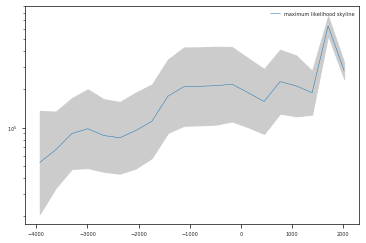

In [65]:
if hasattr(tt, "merger_model"):
    #skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=N_STD)
    #print(skyline)
    #print(conf)
    out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )
    treetime.wrappers.print_save_plot_skyline(tt, 
                                              plot=out_path_skyline_pdf, 
                                              save=out_path_skyline_txt,
                                              screen=True,
                                              n_std=2.0, )

## Add Metadata as Comments

In [66]:
metadata_to_comment(tt.tree, tree_df)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



---
# Export

## Dataframe

In [71]:
# Dataframe
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Timetrees

In [74]:
# Phyloxml
tt_copy = copy.deepcopy(tt)
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_timetree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_timetree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_timetree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_timetree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))


1

## Divtrees

In [75]:
tt_copy = copy.deepcopy(tt)
# Convert to divtree
for n in tt_copy.tree.find_clades():
    n.branch_length=n.mutation_length

# Phyloxml
out_path_xml = os.path.join(outdir,  SCRIPT_NAME + "_divtree.xml" )
Phylo.write(tt_copy.tree, out_path_xml, 'phyloxml')

# Nexus
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + "_divtree.nexus" )
Phylo.write(tt_copy.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

# Dill object
out_path_dill_tree = os.path.join(outdir,  SCRIPT_NAME + "_divtree.treetime.obj" )
with open(out_path_dill_tree,"wb") as outfile:
    dill.dump(tt_copy, outfile)
    
# Newick (remove comments)
for c in tt_copy.tree.find_clades(): c.comment = None
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + "_divtree.nwk" )
Phylo.write(tt_copy.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Augur JSON

In [68]:
import importlib
import sys
importlib.reload(sys.modules['config'])
from config import augur_export

In [69]:
augur_dict = augur_export(
    tree_path=out_path_nwk, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
    augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': 4.167237112130312e-08, 'rate_fold_change': 4.498529670137764, 'mutation_length': 1.720110095684973e-06, 'raw_date': '1991-12-22', 'num_date': 1991.9737186953694, 'num_date_confidence': [1992.0, 1992.0], 'num_date_bar': '29.0:29.0', 'clock_length': 26.09605904591581}


## Auspice JSON

In [70]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

<class 'dict'>
Validating schema of '../../config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '../../results/clock_model/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '../../results/clock_model/clock_model_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_clock-model.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_clock-model.json' succeeded.
Validation successful for remote JSON.
